In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

#### Task 2: Bayesian Linear Regression

In [2]:
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

In [3]:
# define a function used to get the design matrix
def get_PHI(x):
    N = len(x)
    ones = np.ones(N).reshape(N, 1)
    PHI = np.concatenate((ones,x), axis=1)
    return PHI

# define a function used to get the accuracy
def get_accuracy(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    SS_tot = ((y - y.mean()) ** 2).sum()
    SS_res = ((y - y_pred) ** 2).sum()
    accuracy = 1 - SS_res / SS_tot
    return accuracy
 
# define a function used to get the root mean squared error
def get_rms(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    err = np.sqrt(np.mean((y-y_pred)**2))
    return err

# define a function used to get the prediction
def predict(target_PHI, weights):
    
    prediction = np.dot(target_PHI, weights)
    
    return prediction

In [4]:
# pre-processing
x_train = np.array(train.iloc[:,:-1]).astype(float)
y_train = np.array(train.iloc[:,-1]).astype(float)
x_test = np.array(test.iloc[:,:-1]).astype(float)
y_test = np.array(test.iloc[:,-1]).astype(float)
PHI_train = get_PHI(x_train)
PHI_test = get_PHI(x_test)

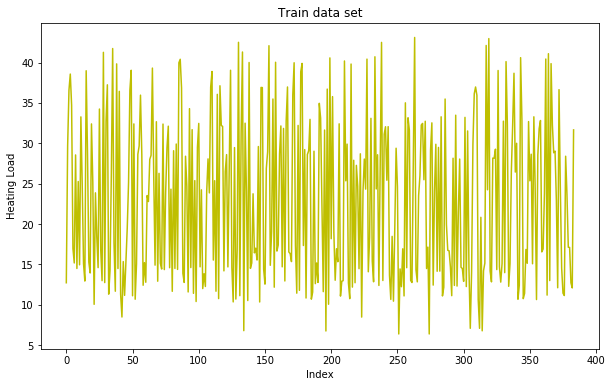

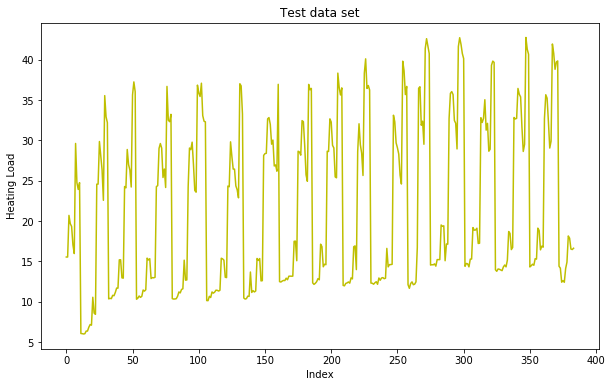

In [5]:
# plot train data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Train data set')
plt.show()

# plot test data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Test data set')
plt.show()

In [9]:
def compute_posterior(PHI,y,alph,s2):
    lam = alph * s2
    I = np.eye(PHI.shape[1])
    Mu = np.dot(np.dot(np.linalg.inv(np.dot(PHI.T,PHI)+lam*I),PHI.T),y)
    SIGMA = s2 * np.linalg.inv(np.dot(PHI.T,PHI)+lam*I)
    return (Mu, SIGMA)

def compute_neg_log_marginal_likelihood(PHI,y,alph,s2):
    I = np.eye(y.shape[0])
    Mean = np.zeros(y.shape[0])
    Covariance = s2 * I + (alph**(-1)) * np.dot(PHI,PHI.T)
    lgp = stats.multivariate_normal.logpdf(y.flatten(), mean = Mean, cov = Covariance, allow_singular = True)
    return -lgp

def Bayes_Linear_Regression(train_PHI, train_y):
    i_alph = np.linspace(-10,10,201)
    i_s2 = np.linspace(-10,10,201)
    alph_space = 10**i_alph
    s2_space = 10**i_s2

    best_alph = 0
    best_s2 = 0
    best_n_lgp = np.inf
    for alph,s2 in itertools.product(alph_space, s2_space):
        n_lgp = compute_neg_log_marginal_likelihood(train_PHI, train_y, alph, s2)
        if n_lgp < best_n_lgp:
            best_n_lgp = n_lgp
            best_alph = alph
            best_s2 = s2      
    Mu, _ = compute_posterior(train_PHI, train_y, best_alph, best_s2)
    print('Best alpha: ', best_alph)
    print('Best $\sigma^2$: ', best_s2)
    
    return Mu


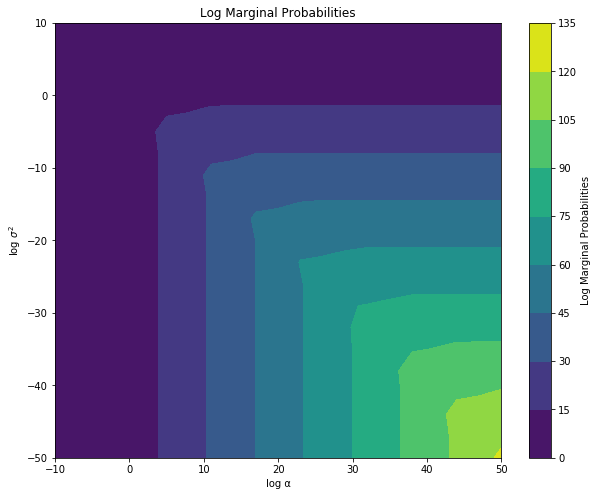

In [55]:
x_alpha = np.linspace(-10,50,21)    # Equally spaced log alpha values
x_s2 = np.linspace(-50,10,21)         # Equally spaced log s2 values

alpha = 10**x_alpha                 # alpha                        
s2 = 10**x_s2                        # sigma-squared


logML_mat = []
ML_mat = []

for i in alpha:
    in_mat = []
    
    for j in s2:
        logML = compute_neg_log_marginal_likelihood(PHI_train, y_train, i, j)   # Calculates logML values for each log alpha and log r value
        in_mat.append(np.log(logML))
        
        
    logML_mat.append(in_mat)  
#     ML_mat.append(in_mat2)
    

    
# Hyperparameter posterior visualization

plt.figure(figsize=(10,8))

plt.contourf(x_alpha, x_s2, np.transpose(logML_mat))
plt.xlabel('log α')
plt.ylabel('log $\sigma^2$')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
# plt.xlim([8, 10])
# plt.ylim([-10,-8.75])
plt.show()    

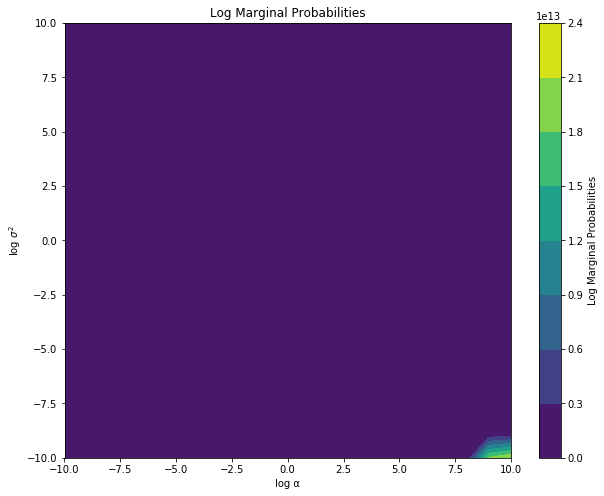

In [43]:
# Hyperparameter posterior visualization

plt.figure(figsize=(10,8))

plt.contourf(x_alpha, x_s2, np.transpose(logML_mat))
plt.xlabel('log α')
plt.ylabel('log $\sigma^2$')
plt.colorbar().ax.set_ylabel('Log Marginal Probabilities')
plt.title('Log Marginal Probabilities')
# plt.xlim([8, 10])
# plt.ylim([-10,-8.75])
plt.show() 

In [39]:
# get accuracy and rms
weights1 = Bayes_Linear_Regression(PHI_train, y_train)
y_train_pred1 = predict(PHI_train, weights1)
y_test_pred1 = predict(PHI_test, weights1)

print('Bayes Linear Regression accuracy on train data set is', get_accuracy(y_train, y_train_pred1)*100, '%')
print('Bayes Linear Regression accuracy on test data set is', get_accuracy(y_test, y_test_pred1)*100, '%')

print('Bayes Linear Regression rms on train data set is', get_rms(y_train, y_train_pred1))
print('Bayes Linear Regression rms on test data set is', get_rms(y_test, y_test_pred1))

Best alpha:  0.00794328234724282
Best $sigma^2$:  5.011872336272735
Bayes Linear Regression accuracy on train data set is 90.84197483863144 %
Bayes Linear Regression accuracy on test data set is 91.85556593712852 %
Bayes Linear Regression rms on train data set is 3.0422569570063396
Bayes Linear Regression rms on test data set is 2.8757887163607054


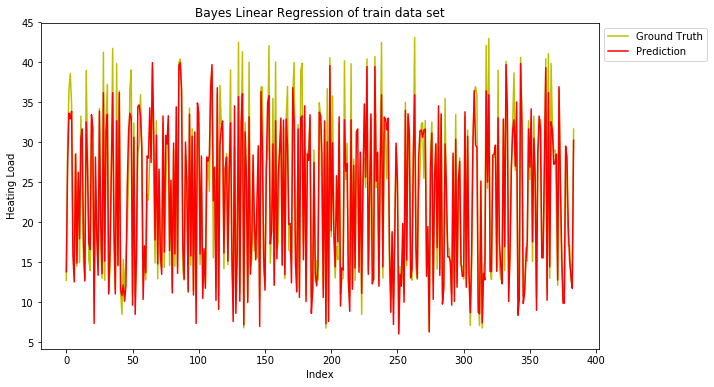

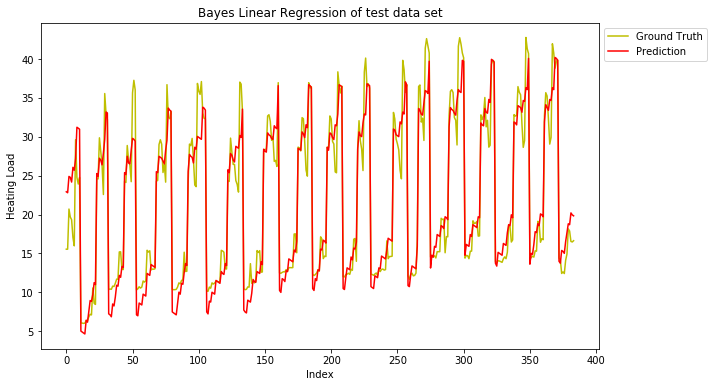

In [8]:
# plot train data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_train)), y_train_pred1, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Bayes Linear Regression of train data set')
plt.show()

# plot test data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_test)), y_test_pred1, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Bayes Linear Regression of test data set')
plt.show()